This notebook doesn't exactly fit into this challenge, but I was chatting with Andy about the question I had in challenge 11 about if it's ok to initialize weights to zero, and we got into how SGD works. I wrote this notebook for him and also for me to start to understand what happens when weights are initialized to zero.

Here is some data I'm making up:
```
---height of turkey--  --length of turkey--   --number of feathers--
   2 feet                3 feet                 23 feathers
   4 feet                5 feet                 43 feathers
```

We want to create a function that will take in height and length and predict number of feathers

Let's set things up and do 2 steps of gradient descent by hand:

```
-we are learning the function f(x1,x2) = x1*a + x2*b (a linear function with no bias term)
-so our goal is to learn a and b, the weights
-we initialize a and b to 0 (but it's more common to initialize them to random numbers)
-our loss function is mean squared error
("error" means y - f(), the correct value minus what the function says)
-so our loss for f(2,3) -> 23 and f(4,5) -> 43 is:
loss(a,b) = ((23 - (2a + 3b))^2 + (43 - (4a + 5b))^2) / 2
          = (4a^2 + 12ab - 92a + 9b^2 - 138b + 529 + 16a^2 + 40ab - 344a + 25b^2 - 430b + 1849) / 2
          = (20a^2 + 52ab - 436a + 34b^2 - 568b + 2378) / 2
          = 10a^2 + 26ab - 218a + 17b^2 - 284b + 1189
partial derivative of loss with respect to a = 20a + 26b - 218
partial derivative of loss with respect to b = 26a + 34b - 284

==step 1==
-calculate gradient at (0,0)
(20a + 26b - 218, 26a + 34b - 284) = (-218, -284)
-so gradient at (0,0) is (-218, -284)
-set our learning rate to .001
a <- a - .001 * -218 = 0 + .218 = .218
b <- b - .001 * -284 = 0 + .284 = .284

==step 2==
-calculate gradient at (.218, .284)
(20a + 26b - 218, 26a + 34b - 284) = (-206.256, -268.676)
a <- .218 - .001 * -206.256 = 0.42426
b <- .284 - .001 * -268.676 = 0.55268

etc.
```

Now let's do it with torch

In [1]:
import torch

In [2]:
x = torch.tensor([[2,3],[4,5]], dtype=torch.float32)
y = torch.tensor([[23], [43]], dtype=torch.float32)
x, y

(tensor([[2., 3.],
         [4., 5.]]),
 tensor([[23.],
         [43.]]))

In [3]:
model = torch.nn.Linear(2, 1, bias=False)

In [4]:
model.weight # these are the random initial weights (what I call a and b above)

Parameter containing:
tensor([[-0.7060,  0.3016]], requires_grad=True)

In [5]:
torch.nn.init.zeros_(model.weight) # but I'm going to force them to 0 and 0

Parameter containing:
tensor([[0., 0.]], requires_grad=True)

In [6]:
# run our function on x, no surprise that it (badly!) predicts 0 feathers for both 
# turkeys beause we're multiplying by weights that are 0
model(x).detach()

tensor([[0.],
        [0.]])

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [8]:
# in the output below, notice that the grads computed in step 0 and step 1 and the updated weights
# (shown as the starting situation for the next step) match the hand calculations above
for step in range(100):
    optimizer.zero_grad()
    output = model(x)
    loss = torch.nn.functional.mse_loss(y, output)
    loss.backward()
    print(f"step {step}, params: {model.weight.detach()}, grad: {model.weight.grad}")
    optimizer.step()

step 0, params: tensor([[0., 0.]]), grad: tensor([[-218., -284.]])
step 1, params: tensor([[0.2180, 0.2840]]), grad: tensor([[-206.2560, -268.6760]])
step 2, params: tensor([[0.4243, 0.5527]]), grad: tensor([[-195.1453, -254.1784]])
step 3, params: tensor([[0.6194, 0.8069]]), grad: tensor([[-184.6338, -240.4625]])
step 4, params: tensor([[0.8040, 1.0473]]), grad: tensor([[-174.6891, -227.4863]])
step 5, params: tensor([[0.9787, 1.2748]]), grad: tensor([[-165.2806, -215.2099]])
step 6, params: tensor([[1.1440, 1.4900]]), grad: tensor([[-156.3796, -203.5954]])
step 7, params: tensor([[1.3004, 1.6936]]), grad: tensor([[-147.9585, -192.6073]])
step 8, params: tensor([[1.4483, 1.8862]]), grad: tensor([[-139.9915, -182.2117]])
step 9, params: tensor([[1.5883, 2.0684]]), grad: tensor([[-132.4542, -172.3768]])
step 10, params: tensor([[1.7208, 2.2408]]), grad: tensor([[-125.3233, -163.0721]])
step 11, params: tensor([[1.8461, 2.4039]]), grad: tensor([[-118.5770, -154.2693]])
step 12, params: t

In [9]:
loss

tensor(0.5291, grad_fn=<MseLossBackward0>)

In [10]:
# now we have non-zero weights that make sense
model.weight

Parameter containing:
tensor([[4.0446, 5.2322]], requires_grad=True)

In [11]:
# and here's what the model now predicts for number of feathers for each turkey
model(x).detach()

tensor([[23.7859],
        [42.3395]])

Plot our loss function and observe that an 'a' of around 4 and a 'b' of around 5 is near the minimum.

In [12]:
import matplotlib.pyplot as plt

In [13]:
a = torch.linspace(0, 8, 100)
b = torch.linspace(0, 8, 100)
A, B = torch.meshgrid(a, b, indexing='ij')
loss = ((23 - (2*A + 3*B)) ** 2 + (43 - (4*A + 5*B)) ** 2) / 2

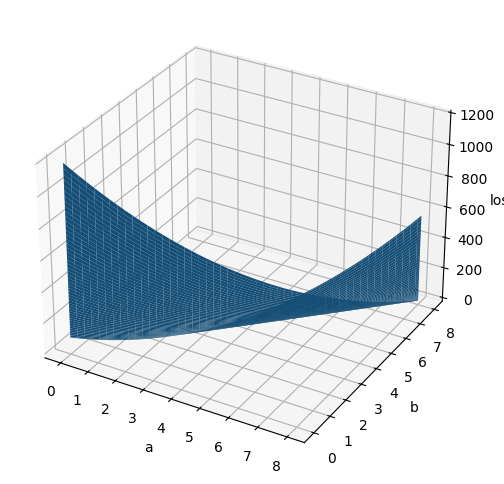

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a, b, loss)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('loss')
plt.show()

Visualize that we started with a,b = 0,0 and did gradient descent to get to the weights we ended with. Dots start with red.

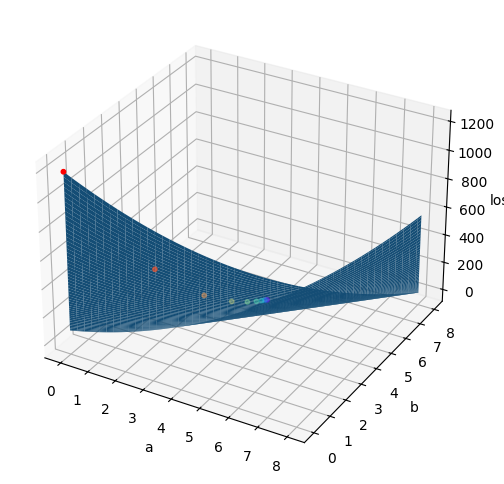

In [15]:
a_s, b_s, losses = [], [], []
torch.nn.init.zeros_(model.weight)
for step in range(100):
    optimizer.zero_grad()
    output = model(x)
    loss = torch.nn.functional.mse_loss(y, output)
    if step % 10 == 0:
        a_s.append(float(model.weight.detach()[0][0]))
        b_s.append(float(model.weight.detach()[0][1]))
        losses.append(float(loss.detach()))
    loss.backward()
    optimizer.step()

loss = ((23 - (2*A + 3*B)) ** 2 + (43 - (4*A + 5*B)) ** 2) / 2
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a, b, loss)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('loss')
t = torch.linspace(1, 0, len(a_s))
ax.scatter(a_s, b_s, losses, s=10, c=t, cmap='rainbow')
plt.show()